## CIFAR10の分類/Google ColabでPytorchのCNN構築

In [1]:
# ライブラリのインポート
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import numpy as np
import matplotlib.pyplot as plt

## 前処理/データの準備

In [2]:
# データの読み込み
cifar10_data = CIFAR10('./data', #データの保存場所
                       train=False, download=True, #Testデータとしてロード
                       transform=transforms.ToTensor()) #tensor型に変換


Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
# ラベルの設定
cifar10_label = np.array(['airplane', 'automobile','bird','cat','deer',
                          'dog','frog','horse','ship','truck'])

In [4]:
print('データ情報:', len(cifar10_data))

データ情報: 10000


In [5]:
# バッチサイズの設定
batch_size = 32

In [6]:
#データローダの設定
cifar10_loader = DataLoader(cifar10_data, batch_size=batch_size, shuffle=True)

テストデータをひとまず読み込んで可視化してみます。

## データの可視化

In [7]:
# 最初のバッチ画像を表示
dataiter = iter(cifar10_loader)
images, labels = dataiter.next() #1つ目のバッチを取り出す。

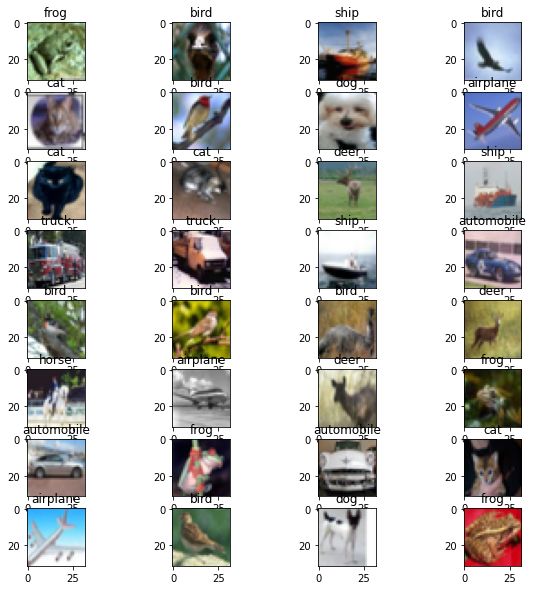

In [8]:
# matplotlibで画像の表示
plt.figure(figsize=(10,10))
for i in range(batch_size):
  plt.subplot(8,4,i + 1)
  plt.imshow(np.transpose(images[i], (1,2,0))) #チャンネルを後ろに配列を変える
  label = cifar10_label[labels[i]]
  plt.title(label)
plt.show()

問題なくデータが読み込まれているので、学習の準備に進みます。

## 学習の準備（訓練データの読み込みと拡張）

ここでは改めて、訓練データとテストデータの両方を設定します。<br>
その際に、訓練データにノイズを加えて訓練します。

In [9]:
# 訓練/テスト用データのCIFAR10を読み込み

#ノイズを設定
affine = transforms.RandomAffine([-15, 15], scale=(0.8, 1.2))  # 回転とリサイズ
flip = transforms.RandomHorizontalFlip(p=0.5)  # 左右反転
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # 標準化処理
to_tensor = transforms.ToTensor()

transform_train = transforms.Compose([affine, flip, to_tensor, normalize])
transform_test = transforms.Compose([to_tensor, normalize]) #テストデータは標準化、テンソル化のみ
cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

# DataLoaderの設定
batch_size = 32
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=len(cifar10_test), shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## CNNの構築

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 畳み込み層:(入力チャンネル数, フィルタ数、フィルタサイズ)
        self.pool = nn.MaxPool2d(2, 2)  # プーリング層:（領域のサイズ, ストライド）
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 256)  # 全結合層
        self.dropout = nn.Dropout(p=0.5)  # ドロップアウト:(p=ドロップアウト率)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net()
net.cuda()  # GPU対応
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


## CNNによる画像データの学習

In [11]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
x_test, t_test = iter(test_loader).next()
x_test, t_test = x_test.cuda(), t_test.cuda()
for i in range(20):  # エポック数の設定
    net.train()  # 訓練用
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチを取り出す
        x, t = x.cuda(), t.cuda()  # GPU設定
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 検証用
    y_test = net(x_test)
    loss_test = loss_fnc(y_test, t_test).item()
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 1.7239660002524777 Loss_Test: 1.453262448310852
Epoch: 1 Loss_Train: 1.5108117019985245 Loss_Test: 1.4294214248657227
Epoch: 2 Loss_Train: 1.4380383935023482 Loss_Test: 1.283402681350708
Epoch: 3 Loss_Train: 1.3907909722413607 Loss_Test: 1.2705594301223755
Epoch: 4 Loss_Train: 1.3554893687071894 Loss_Test: 1.2022974491119385
Epoch: 5 Loss_Train: 1.3253084622890767 Loss_Test: 1.2306386232376099
Epoch: 6 Loss_Train: 1.3128457573157277 Loss_Test: 1.160664439201355
Epoch: 7 Loss_Train: 1.2973250534697671 Loss_Test: 1.152074933052063
Epoch: 8 Loss_Train: 1.2771670672654039 Loss_Test: 1.166964054107666
Epoch: 9 Loss_Train: 1.2669341968025676 Loss_Test: 1.2123514413833618
Epoch: 10 Loss_Train: 1.2613053253577142 Loss_Test: 1.125479817390442
Epoch: 11 Loss_Train: 1.2541199588501064 Loss_Test: 1.1293262243270874
Epoch: 12 Loss_Train: 1.23976916787873 Loss_Test: 1.0757973194122314
Epoch: 13 Loss_Train: 1.233736622127599 Loss_Test: 1.1072251796722412
Epoch: 14 Loss_Train: 1.2

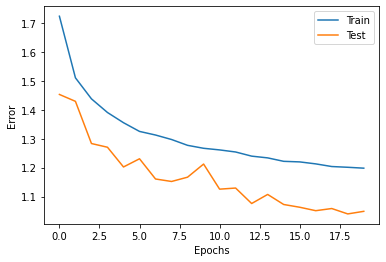

In [12]:
#訓練データとテストデータのロス推移
plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

順調にロスがエポックごとに減っているのがわかります。

In [13]:
#画像の正解率を算出
correct = 0
total = 0
net.eval()  
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 63.28%


## ランダムに画像を取り出して判別

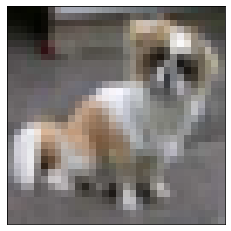

正解: dog 予測結果: cat


In [15]:
cifar10_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)
dataiter = iter(cifar10_loader)
images, labels = dataiter.next()

plt.imshow(np.transpose(images[0], (1, 2, 0)))  
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
plt.show()

net.eval()
x, t = images.cuda(), labels.cuda() 
y = net(x)
print("正解:", cifar10_label[labels[0]],
      "予測結果:", cifar10_label[y.argmax().item()])

精度は高くありませんが、pytorchの基本的なCNNを構築できました。<br>